# Model for predicting Second Language Adquisiton

We start by loading the necessary libraries.

In [1]:
from fastai.data.all import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification
import pandas as pd
from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import NLP as BLURR # lo importamos así para que sea compatible con el resto
from datasets import load_dataset, concatenate_datasets

/home/jonathan/.virtualenvs/huggingface/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
import torch
torch.cuda.set_device(2)

Now, we load the train and validation sets.

In [3]:
train_df = pd.read_csv('perplejidad/datasets/train_train_set.csv',delimiter='\t')

In [4]:
valid_df = pd.read_csv('perplejidad/datasets/validation_train_set.csv',delimiter='\t')

In [5]:
len(train_df),len(valid_df)

(33684, 3743)

In [6]:
train_df['is_valid']=False

In [7]:
valid_df['is_valid']=True

In [8]:
train_valid_df = pd.concat([train_df,valid_df])

We define the indexes for training and validation.

In [9]:
train_idxs, valid_idxs = L(range(len(train_valid_df[train_valid_df.is_valid==False]))), L(range(len(train_valid_df[train_valid_df.is_valid==False]), len(train_valid_df)))

Now, we can define the model. In this case, we use a predefined model called Roberta.

In [10]:
dl_kwargs = {"bs": 64, "val_bs": 64}
learn_kwargs = {"metrics": [accuracy]}

In [11]:
learn = BlearnerForSequenceClassification.from_data(
    train_valid_df,
    "xlm-roberta-base",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(valid_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [12]:
learn = learn.to_fp16()

In [13]:
learn.dls.show_batch(dataloaders=learn.dls, trunc_at=500, max_n=5)

,text,target
0,"Pes estabamos en el kamra esperando un taxi de_repente pasó a+mi a+mi lado un homdre bien vestido preguntando la dirección+de dirección+de el hospita ibn_sina, de_repente se fue y me entere+qe entere+qe me habia+robado+la+cartera habia+robado+la+cartera habia+robado+la+cartera habia+robado+la+cartera",B1
1,"Fuera estudiar, yo conocir muchos sitios buenissimos, Cerro_de_Santa_Lucia, La_Plaza_de_Armas, La_Plaza_Italia, la casa de Pablo_Neruda, conoci un metro y tambien fue esquiar en La_Parva.",A2
2,"SOY SOUHAIR_ALAMI, MARROQUI DE FEZ, HABLO EL ARABE, ESTUDIO ESPAÑOL EN INSTUTO_SERVANTES EN FEZ Y ESTUDIO ENGLES EN EL CENTRO AMERICANO TAMBIEN EN FEZ.",A1
3,"Necesito un triple con tres baños independientes, aire acondicionado, un bueno minibar, y el más importante : vistas hermosas a el mar. Quería este habitación por tres semanas, de el ocho_de_Deciembre hasta el vientenueve_de_Deciembre.",A2
4,"Me llamo Thaiane_Cristovam, soy brasileña, vivo en Porto_Alegre, estudio derecho en la universidad PUC, tengo 20 años, soy baja, no soy ni gorda ni delgada, tengo el pelo castaño y ojos marrones.",A1


In [14]:
learn.fine_tune(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.031891,0.935013,0.630777,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.678253,0.635197,0.756612,01:05
1,0.619236,0.598033,0.775047,01:05
2,0.562767,0.576249,0.791077,01:03
3,0.446963,0.648576,0.782527,01:05
4,0.373568,0.606861,0.790542,01:06
5,0.324903,0.639340,0.795886,01:06
6,0.258174,0.741532,0.795618,01:06
7,0.177378,0.853892,0.795084,01:06
8,0.105825,0.944509,0.794817,01:06
9,0.098024,0.953489,0.795618,01:06


In [15]:
learn.export('xlm-roberta-base.pkl')

In [16]:
learn.save('xlm-roberta-base')

Path('models/xlm-roberta-base.pth')

In [17]:
test_df = pd.read_csv('perplejidad/datasets/test_set.csv',delimiter='\t')

In [18]:
test_df['is_valid']=True

In [19]:
len(train_df)

33684

In [20]:
train_test_df = pd.concat([train_df,test_df])

In [21]:
train_idxs, test_idxs = L(range(len(train_test_df[train_test_df.is_valid==False]))), L(range(len(train_test_df[train_test_df.is_valid==False]), len(train_test_df)))

In [22]:
learnTest = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "xlm-roberta-base",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [23]:
learnTest.load('xlm-roberta-base')

In [24]:
learnTest.validate()

(#2) [0.957776665687561,0.797370970249176]

In [25]:
preds,gt=learnTest.get_preds()

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
cm = confusion_matrix(gt, np.argmax(preds,axis=1))

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=learnTest.dls.vocab)

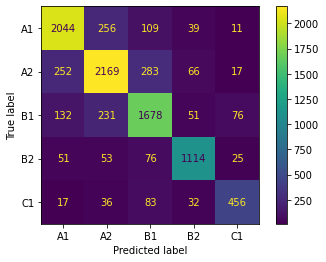

In [29]:
disp.plot()